# Decision Trees in Practice

In this section, we will train decision trees using Python on the Titanic dataset. The Titanic disaster is one of the most well-known shipwrecks in history. On the night of April 14, 1912, during its first voyage, the RMS Titanic struck an iceberg and sank in the early hours of April 15. Because the ship did not carry enough lifeboats for all passengers and crew, more than half of those on board lost their lives. While chance played a role, survival was not random, and some groups of passengers had higher survival rates than others. 

Our goal is to build a predictive model that, given information about a passenger, predicts whether that person was likely to survive. We will begin by fitting a simple decision tree and then explore how model choices such as tree depth affect performance.

## Loading and Preparing the Dataset

First, we load the Titanic dataset and examine its structure. This dataset contains information about 891 passengers including age, gender, class, and survival outcome. The data used in this example is obtained from [Kaggle](https://www.kaggle.com/datasets/yasserh/titanic-dataset?resource=download).

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np

In [2]:
# Load the dataset
Titanic_df = pd.read_csv("Titanic-Dataset.csv")
Titanic_df

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [3]:
# Examine basic information
Titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The dataset includes 12 columns. The column `Cabin`, have many missing values. The columns `Age` and `Embarked` also have some missing entries.

To simplify our analysis, we perform the following preprocessing steps:

1. First, drop the `Cabin` column because most of its entries are missing.
2. Then, drop any rows containing missing values.

In [4]:
# Drop 'Cabin' column
Titanic_df = Titanic_df.drop('Cabin', axis=1)

# Drop rows with missing values
Titanic_df = Titanic_df.dropna()

# Check the cleaned dataset
Titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          712 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 66.8+ KB


After cleaning, the dataset contains 712 passengers with 11 columns. The table below summarizes each feature along with its description and possible values.

The cleaned Titanic dataset contains the following features:

<center>

| Feature    | Description                                    | Possible Values / Type                          |
|------------|-----------------------------------------------|-----------------------------------------------|
| `Pclass`   | Passenger class, indicating socio-economic status | 1 (First), 2 (Second), 3 (Third)             |
| `Sex`      | Passenger’s gender                             | male, female                                  |
| `Age`      | Passenger’s age in years                        | Numeric                           |
| `SibSp`    | Number of siblings or spouses aboard           | 0, 1, 2, …                                   |
| `Parch`    | Number of parents or children aboard           | 0, 1, 2, …                                   |
| `Fare`     | Ticket fare paid by the passenger              | Numeric                           |
| `Embarked` | Port of embarkation                             | C = Cherbourg, Q = Queenstown, S = Southampton |
| `Survived` (Target variable) | Survival status               | 0 = Did not survive, 1 = Survived            |

</center>

Note that:

- Features such as `PassengerId`, `Name`, and `Ticket` are identifiers and will not be used in modeling.  
- `Pclass`, `Sex`, and `Embarked` are categorical features. We convert `Sex` and `Embarked` into numeric codes because decision tree implementations in Python require numerical inputs.
- `Age`, `Fare`, `SibSp`, and `Parch` are numeric features.  
- The target variable is `Survived`, which is a binary variable.

:::{note}
Decision trees, in theory, can handle categorical features directly by splitting on each category. However, some versions of scikit-learn require numeric inputs. That’s why we convert features like `Sex` and `Embarked` into numeric codes.
:::

In [5]:
# Removing the identifier columns
Titanic_df = Titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

# Converting the string labels to numerical labels
Titanic_df['Sex_coded']=pd.Categorical(Titanic_df['Sex']).codes
Titanic_df['Embarked_coded']=pd.Categorical(Titanic_df['Embarked']).codes

# Drop 'Sex' and 'Embarked' columns 
Titanic_df = Titanic_df.drop(['Sex', 'Embarked'], axis=1)

# Renaming the columns 'Sex_coded' and 'Embarked_coded' 
Titanic_df = Titanic_df.rename(columns={'Sex_coded': 'Sex', 'Embarked_coded': 'Embarked'})

Titanic_df

Survived  Pclass   Age  SibSp  Parch     Fare  Sex  Embarked
0           0       3  22.0      1      0   7.2500    1         2
1           1       1  38.0      1      0  71.2833    0         0
2           1       3  26.0      0      0   7.9250    0         2
3           1       1  35.0      1      0  53.1000    0         2
4           0       3  35.0      0      0   8.0500    1         2
..        ...     ...   ...    ...    ...      ...  ...       ...
885         0       3  39.0      0      5  29.1250    0         1
886         0       2  27.0      0      0  13.0000    1         2
887         1       1  19.0      0      0  30.0000    0         2
889         1       1  26.0      0      0  30.0000    1         0
890         0       3  32.0      0      0   7.7500    1         1

[712 rows x 8 columns]

Before building our decision trees, we need to split the data into training and test sets. We create this split using the `train_test_split` function from scikit-learn's `model_selection` module.

In [6]:
from sklearn.model_selection import train_test_split

X = Titanic_df.drop(columns=['Survived'])
y = Titanic_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Decision Trees in Python

We train a decision tree model in Python using scikit-learn's `DecisionTreeClassifier` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)). If we were working on a regression task, we would use `DecisionTreeRegressor`. We also import `plot_tree` to visualize the structure of the decision tree we construct.

In [7]:
# Import libraries

from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

We set the `random_state` hyperparameter to ensure reproducibility. This ensures we get the same tree structure each time we run the code.

All other hyperparameters are set to their default values. For example, 

- `max_depth`: Maximum depth of the tree (default = `None`, meaning unlimited)
- `min_samples_split`: Minimum samples required to split an internal node (default = 2)
- `min_samples_leaf`: Minimum samples required at a leaf node (default = 1)

We will experiment with these parameters later to see how they affect model performance. 

At this stage, the tree will grow until all leaves are pure (all observations belonging to a single class) or contain fewer than `min_samples_split` samples. This unrestricted growth may lead to overfitting. Now we initialize and train our decision tree classifier:

In [8]:
# Initialize the decision tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

We can check the depth of our tree and the number of leaves it contains:

In [9]:
print(f"Tree depth: {dt.get_depth()}")
print(f"Number of leaves: {dt.get_n_leaves()}")

Tree depth: 18
Number of leaves: 133


We can visualize this decision tree using `plot_tree` to see its structure and decision rules:

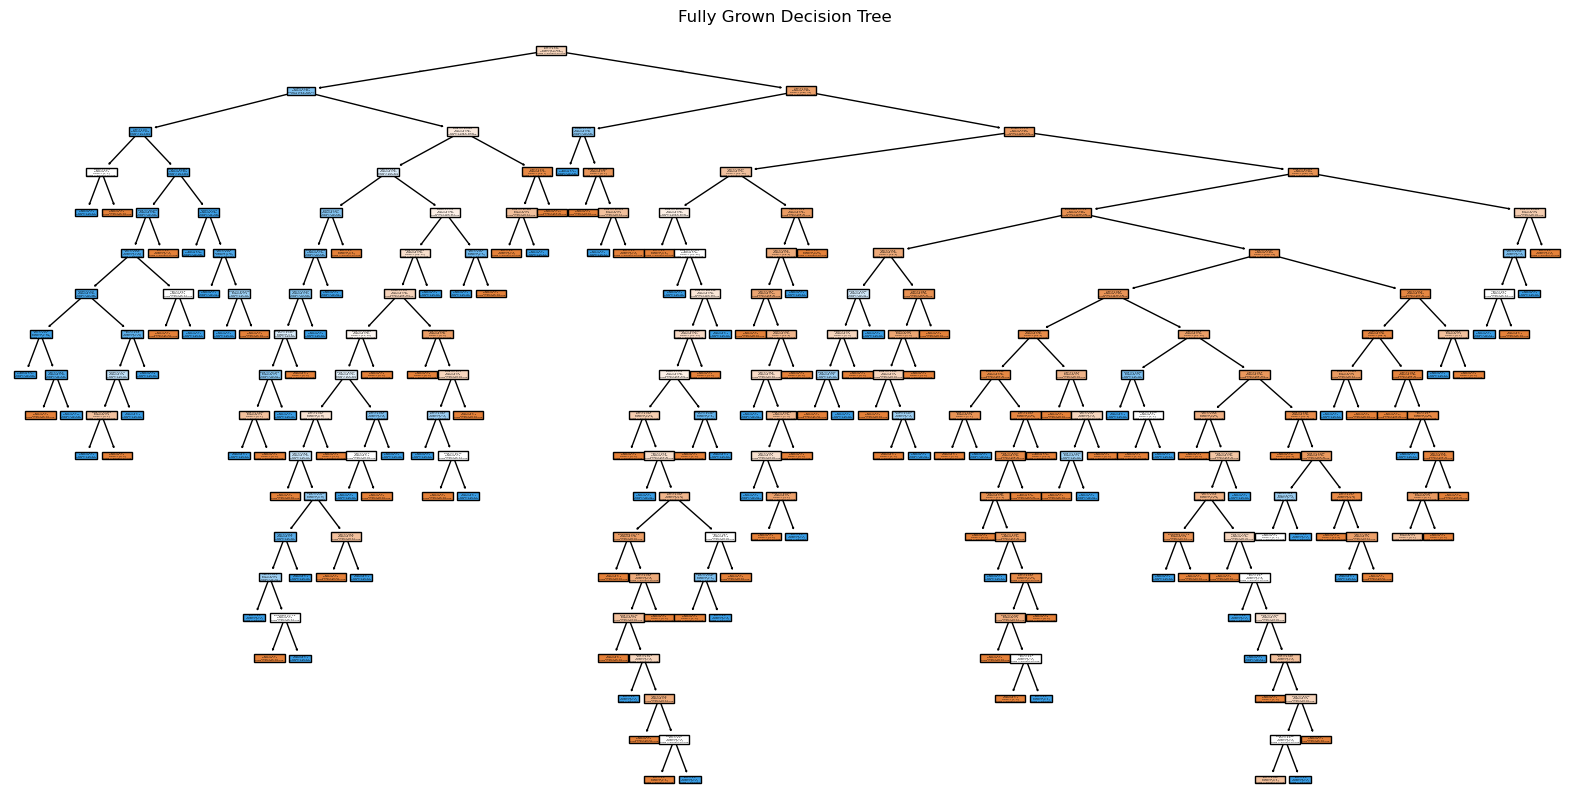

In [10]:
plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, class_names=['Did Not Survive', 'Survived'], filled=True)
plt.title("Fully Grown Decision Tree")
plt.show()

The fully grown decision tree is difficult to visualize and read because it has too many branches. To make it more readable, we can limit the visualization to show only the top few levels (e.g., `max_depth=2`). This allows us to see the most important decision rules i.e. the strongest patterns in the data.

Note that we are only limiting the *visualization* depth here and the actual trained tree remains fully grown. We are simply showing the top 2 levels for clarity.

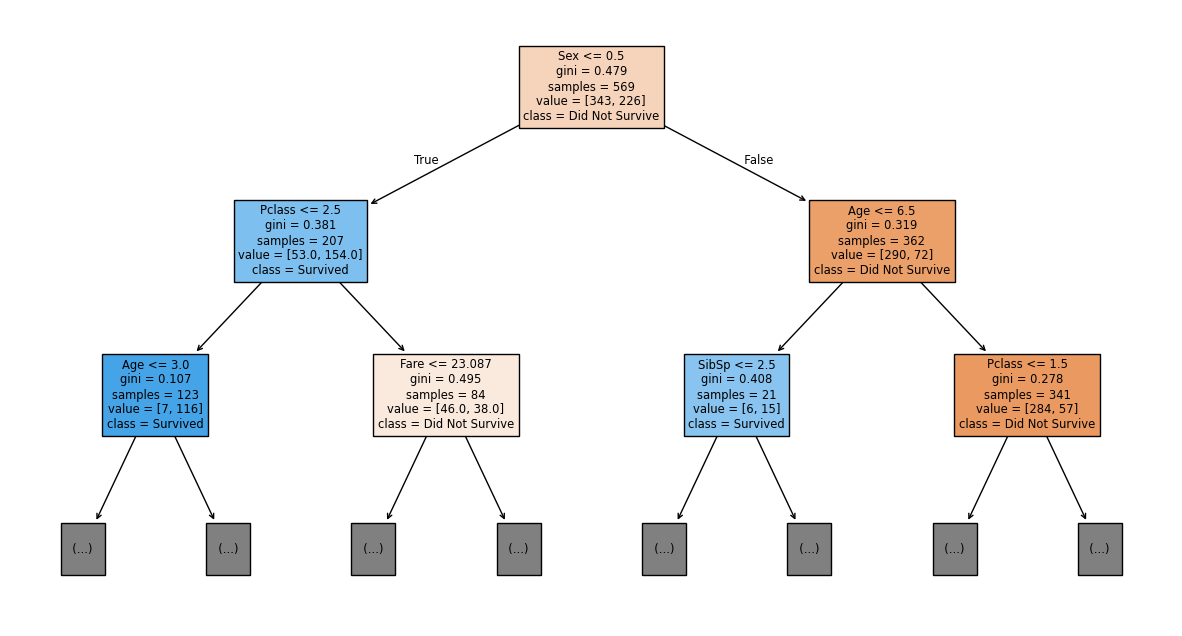

In [11]:
plt.figure(figsize=(15,8))
plot_tree(dt, feature_names=X.columns, class_names=['Did Not Survive', 'Survived'], filled=True, max_depth=2)
plt.show()

Let's interpret the top 2 levels of our decision tree:

**Root Node (Top):**
The root node contains all 569 training samples, with 343 who did not survive and 226 who survived. Since 343 > 226, this node predicts "Did Not Survive". The Gini impurity of 0.479 indicates the classes are fairly mixed.

The split rule `Sex <= 0.5` asks: "Is the passenger female?" (recall we encoded 0 = female, 1 = male):
- Left branch (True): Passengers with Sex ≤ 0.5 (females)
- Right branch (False): Passengers with Sex > 0.5 (males)

**Left Child - Females:**
This node contains the 207 passengers who satisfied the condition Sex ≤ 0.5:
- `value = [53, 154]`: 53 did not survive, 154 survived
- Predicted class: Survived (154 > 53) i.e. women passengers are more likely to survive. 

If the tree continues, these passengers will be further split by `Pclass <= 2.5` (first/second class vs. third class).

**Right Child - Males:**
This node contains the 362 passengers who did not satisfy the condition Sex ≤ 0.5:
- `value = [290, 72]`: 290 did not survive, 72 survived
- Predicted class: Did Not Survive (290 > 72) i.e. men were less likely to survive.

If the tree continues, these passengers will be further split by `Age <= 6.5` (young children vs. older passengers).

So far, `Sex` was the strongest predictor of survival, with females having much higher survival rates (74%) compared to males (20%). This reflects the "women and children first" evacuation policy.

:::{note}
The color of each node indicates its predicted class:
- Orange shades: Predict "Did Not Survive" (class 0)
- Blue shades: Predict "Survived" (class 1)

The intensity of the color reflects prediction confidence. Darker colors indicate more pure nodes with lower Gini impurity values.
:::

We now make predictions on the test set and evaluate the model's accuracy. We use the `accuracy_score` function from `sklearn.metrics` to measure performance.

In [12]:
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred = dt.predict(X_test)

# Calculate test accuracy
dt_accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

Decision Tree Accuracy: 0.7203


Our decision tree achieves approximately 72% accuracy on the test data. To check for overfitting, we also calculate the training accuracy. A very high training accuracy combined with much lower test accuracy indicates overfitting i.e. the tree has memorized the training data rather than learned general patterns. Since we grew our tree without any depth restrictions, we expect to see some overfitting.

In [13]:
# Checking the training accuracy
dt_accuracy_training = accuracy_score(y_train, dt.predict(X_train))
print(f"Decision Tree Training Accuracy: {dt_accuracy_training:.4f}")

Decision Tree Training Accuracy: 0.9947


The training accuracy is nearly perfect (approximately 99%), while test accuracy is only 72%. This large gap confirms overfitting: the tree has memorized the training data rather than learning generalizable patterns.

To prevent overfitting, we can limit the tree's growth by adjusting hyperparameters such as `max_depth` (maximum tree depth) or `min_samples_leaf` (minimum samples per leaf). Let us train a new decision tree with a maximum depth of 3:

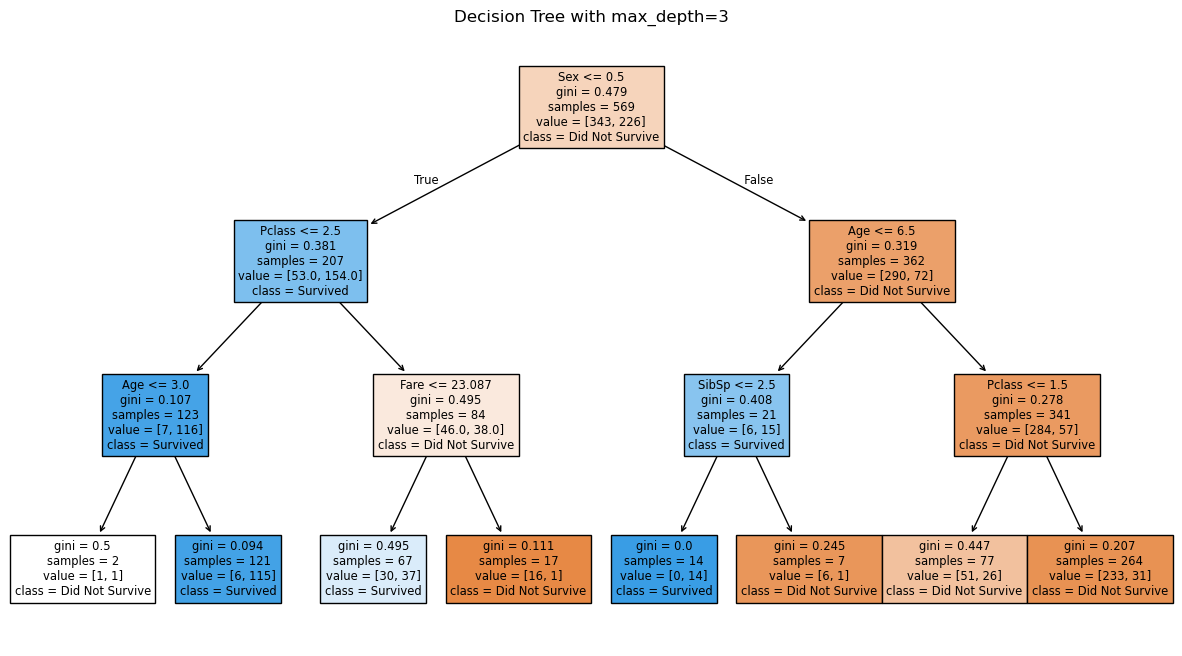

In [14]:
# Train a decision tree with pre-pruning (max_depth=3)
dt_pruned = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_pruned.fit(X_train, y_train)

# Visualize the pruned tree
plt.figure(figsize=(15, 8))
plot_tree(dt_pruned, feature_names=X.columns, class_names=['Did Not Survive', 'Survived'], filled=True)
plt.title("Decision Tree with max_depth=3")
plt.show()

The pruned tree is shallower with fewer branches. Each split now represents a stronger, more generalizable pattern rather than capturing every small variation in the training data. Let us calculate its test and training accuracy to see if we have reduced overfitting:

In [15]:
# Checking the training accuracy
dt_pruned_accuracy_training = accuracy_score(y_train, dt_pruned.predict(X_train))
print(f"Pruned Decision Tree Training Accuracy: {dt_pruned_accuracy_training:.4f}")

# Test accuracy
dt_pruned_accuracy_test = accuracy_score(y_test, dt_pruned.predict(X_test))
print(f"Pruned Decision Tree Test Accuracy: {dt_pruned_accuracy_test:.4f}")

Pruned Decision Tree Training Accuracy: 0.8313
Pruned Decision Tree Test Accuracy: 0.7762


We notice that the test accuracy has increased from 72.0% to 77.6%, while the training accuracy decreased from 99.4% to 83.1%. This is exactly what we wanted: the gap between training and test accuracy is now much smaller (83.1% - 77.6% = 5.5% vs. the original gap of 27.4%). The pruned tree learns general patterns rather than memorizing training data noise, resulting in better performance on unseen data.

Let us create an even shallower tree with `max_depth=2` to see if we can further reduce overfitting:

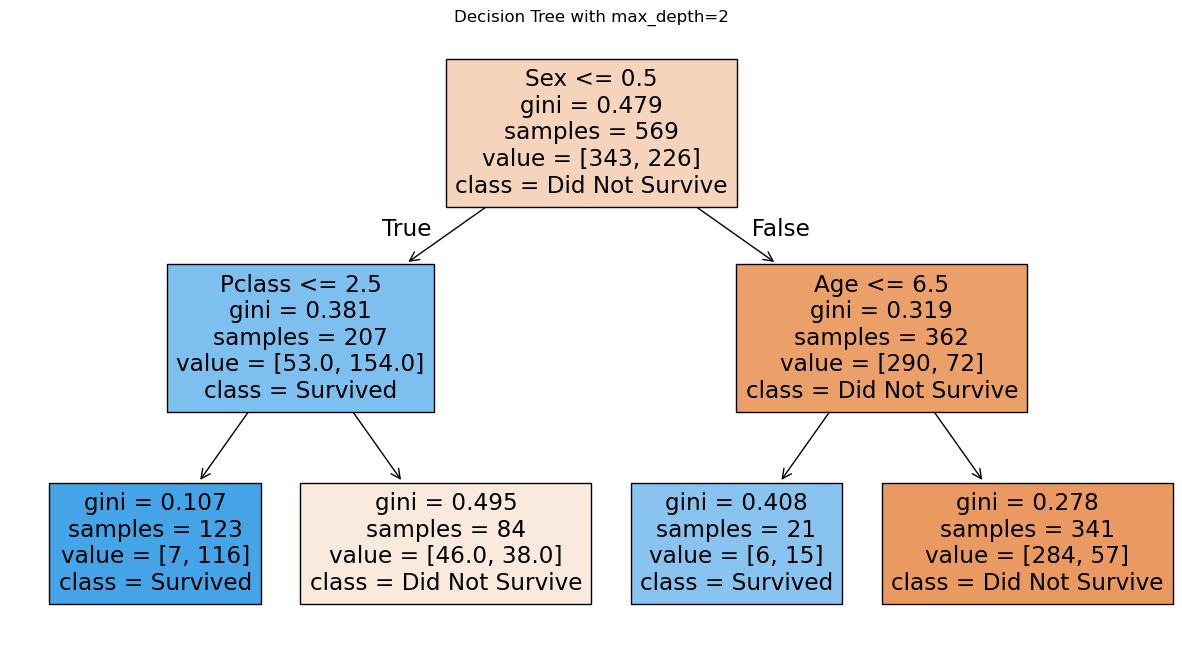

In [16]:
# Train an even shallower decision tree (max_depth=2)
dt_pruned_shallow = DecisionTreeClassifier(max_depth=2, random_state=42)
dt_pruned_shallow.fit(X_train, y_train)

# Visualize
plt.figure(figsize=(15, 8))
plot_tree(dt_pruned_shallow, feature_names=X.columns, class_names=['Did Not Survive', 'Survived'], filled=True)
plt.title("Decision Tree with max_depth=2")
plt.show()

In [17]:
# Check training accuracy
dt_pruned_shallow_accuracy_training = accuracy_score(y_train, dt_pruned_shallow.predict(X_train))
print(f"Shallow Decision Tree (max_depth=2) Training Accuracy: {dt_pruned_shallow_accuracy_training:.4f}")

# Check test accuracy
dt_pruned_shallow_accuracy_test = accuracy_score(y_test, dt_pruned_shallow.predict(X_test))
print(f"Shallow Decision Tree (max_depth=2) Test Accuracy: {dt_pruned_shallow_accuracy_test:.4f}")

Shallow Decision Tree (max_depth=2) Training Accuracy: 0.8102
Shallow Decision Tree (max_depth=2) Test Accuracy: 0.7692


We see here that making the tree shallower did not improve We see that making the tree shallower did not improve performance. Compared to the tree with max_depth=3 (test accuracy: 77.6%), the shallower tree achieves only 76.9% test accuracy. Both training and test accuracy decreased, which indicates underfitting: the model is too simple to capture important patterns in the data.

We face a tradeoff:
- Very deep trees overfit (memorize training data)
- Very shallow trees underfit (miss important patterns)
- We need to find the optimal depth that balances the two

We should aim to find the optimal hyperparameter values that give us the best test accuracy while balancing overfitting and underfitting. We will discuss a technique called Grid Search later in the chapter that systematically determines those hyperparameter values.

For now, let us focus on just the `max_depth` parameter while keeping all others at their default values. We will plot both training and test accuracy versus tree depth to visualize the overfitting-underfitting tradeoff and identify the optimal depth.

In [18]:
# Test different max_depth values
train_accuracy = []
test_accuracy = []

for depth in range(1, 20):
    # Train tree with current depth
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train, y_train)
    
    # Calculate and store accuracies
    train_accuracy.append(accuracy_score(y_train, dt_model.predict(X_train)))
    test_accuracy.append(accuracy_score(y_test, dt_model.predict(X_test)))

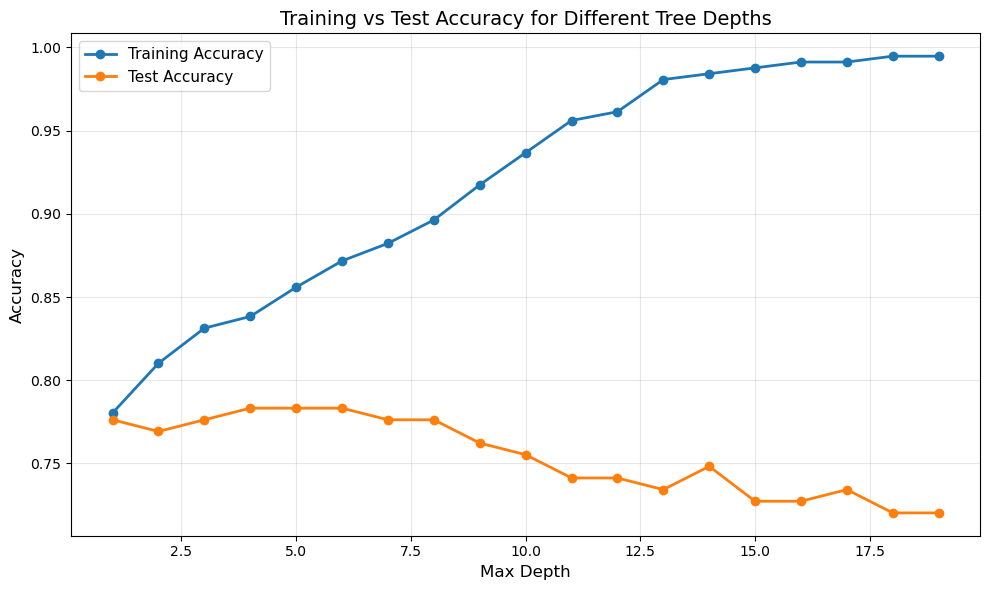

In [19]:
# Plot training and test accuracy vs max_depth
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), train_accuracy, label='Training Accuracy', marker='o', linewidth=2)
plt.plot(range(1, 20), test_accuracy, label='Test Accuracy', marker='o', linewidth=2)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Test Accuracy for Different Tree Depths', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

From the plot, we can observe the classic overfitting-underfitting tradeoff:

1. Training accuracy (blue line) increases steadily with tree depth, approaching nearly perfect accuracy for very deep trees. This shows that deeper trees can fit the training data better.

2. Test accuracy (orange line) initially increases as depth increases, reaches a peak, and then either plateaus or decreases as the tree becomes too complex. This indicates that beyond a certain depth, the tree begins to overfit.

3. The gap between training and test accuracy grows larger as depth increases, which is a clear sign of overfitting. The model memorizes the training data rather than learning generalizable patterns.

The optimal depth is where test accuracy is highest, providing the best balance between underfitting and overfitting. We calculate the optimal depth below:

In [20]:
# Find and display optimal depth
optimal_depth = test_accuracy.index(max(test_accuracy)) + 1  # +1 because range starts at 1 and python counts indices from 0
optimal_test_accuracy = max(test_accuracy)
print(f"Optimal max_depth: {optimal_depth}")
print(f"Test accuracy at optimal depth: {optimal_test_accuracy:.4f}")

Optimal max_depth: 4
Test accuracy at optimal depth: 0.7832


Our optimal tree has max_depth=4, achieving 78.3% test accuracy. Let us visualize this optimal tree:

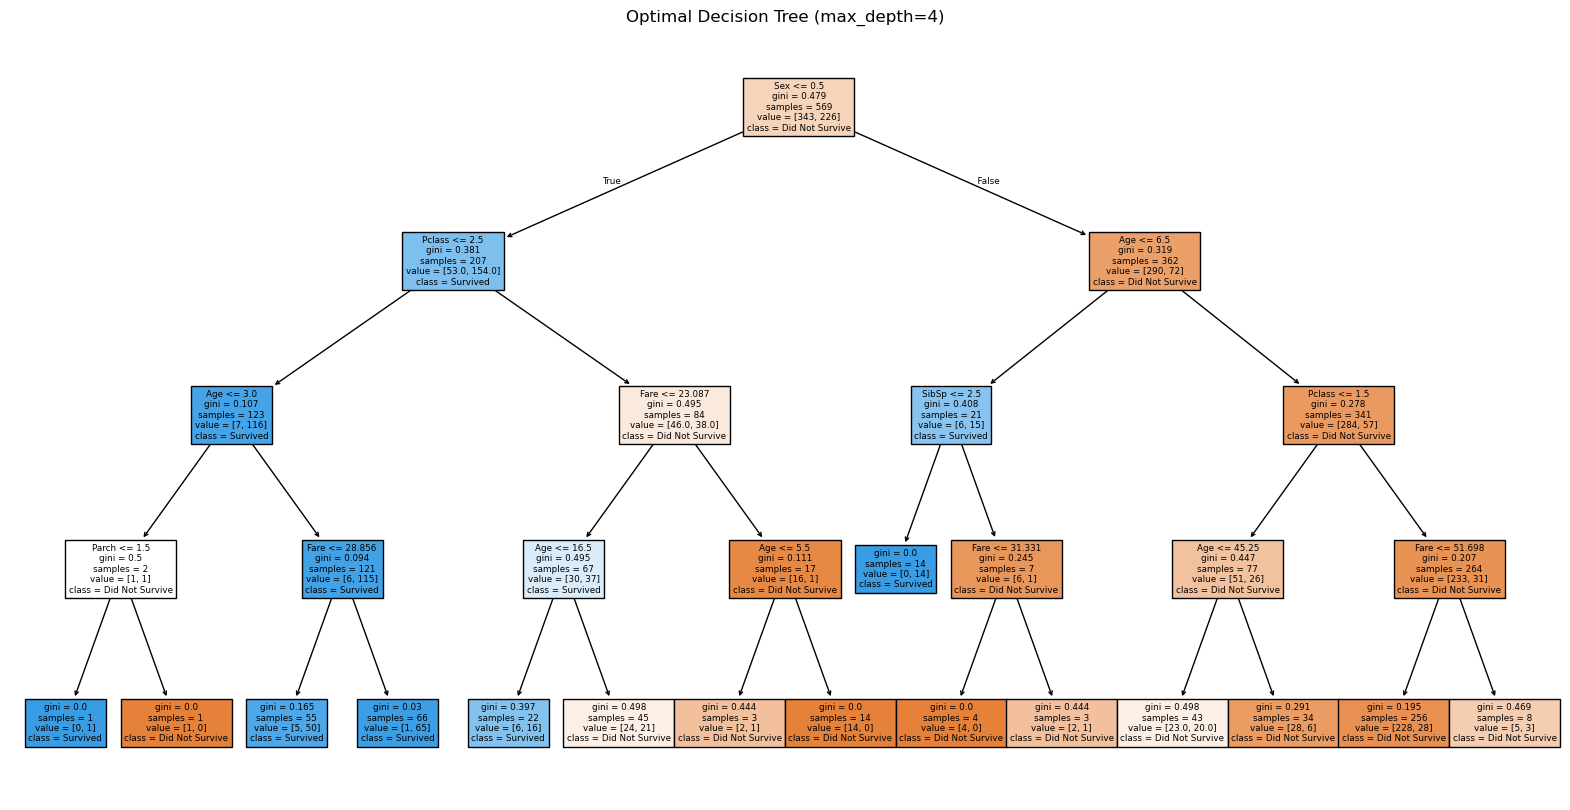


Optimal Tree Performance:
Training Accuracy: 0.8383
Test Accuracy: 0.7832


In [21]:
# Train the optimal tree
dt_optimal = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
dt_optimal.fit(X_train, y_train)

# Visualize
plt.figure(figsize=(20, 10))
plot_tree(dt_optimal, feature_names=X.columns, class_names=['Did Not Survive', 'Survived'], filled=True)
plt.title(f"Optimal Decision Tree (max_depth={optimal_depth})")
plt.show()

# Show training vs test accuracy
print(f"\nOptimal Tree Performance:")
print(f"Training Accuracy: {accuracy_score(y_train, dt_optimal.predict(X_train)):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, dt_optimal.predict(X_test)):.4f}")